# Image Alignment from Spectral Cubes

The data in this notebook is a set of four simulated IFU cubes from David Law.  The first two dithers (Sequence 1 and 2) are aligned and the second two dithers (Sequence 3 and Sequence 4) are aligned with each other but not with Sequence 1 and 2.

Two steps will happen in here. First, all images are reprojected onto Sequence 1 (using the WCS information stored in the file). Then, the images are aligned using a few different techniques.

All of this is done using a single slice, at this point. 

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from reproject import reproject_interp
from scipy import signal
from image_registration import cross_correlation_shifts, chi2_shifts, register_images


Small container class defined just to store some basic info, so things don't have to be repeated.

In [2]:
class IFU(object):

    def __init__(self, filename):
        self.s3d = SpectralCube.read(filename, hdu=1)
        self._slice_number = int(self.s3d.shape[0]//2)
        
        self.spectral_slice = self.s3d[self._slice_number]
        
    def data(self, slice_number):
        spectral_slice = self.s3d[slice_number]
        data = np.array(spectral_slice)
        return data, spectral_slice.wcs

def show(data, title):
    # Display a single image with WCS projection
    pp = np.nanpercentile(data, (1, 99))
    plt.imshow(data, origin='lower', cmap=plt.gray())
    plt.clim(*pp)
    plt.grid(color='white', ls='solid')
    plt.title(title, fontsize=12)

In [3]:
sl = 430

# det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits
ifu1 = IFU('https://stsci.box.com/shared/static/vqh4k4uzxwauh59xn5ksj6v19xeqvg87.fits')

# det_image_seq2_MIRIFUSHORT_12SHORTexp1_s3d.fits
ifu2 = IFU('https://stsci.box.com/shared/static/26yl2k3hwp9c2jfj4cvdl6zk967x5fr5.fits')

# det_image_seq3_MIRIFUSHORT_12SHORTexp1_s3d.fits
ifu3 = IFU('https://stsci.box.com/shared/static/ysq4qk76mau1bw0krn1bim6fqilv2ocx.fits')

# det_image_seq4_MIRIFUSHORT_12SHORTexp1_s3d.fits
ifu4 = IFU('https://stsci.box.com/shared/static/0ke8k8ltzhgwkkbghvsmvqu0p1qkau9h.fits')

 [Done]


/home/travis/miniconda/envs/test/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


 [Done]


 [Done]


 [Done]


In [4]:
assert np.allclose(ifu1.data(sl)[0][20,10:15], np.array([-0.47828794, -0.7783276 , -1.2305702 , -0.80176985, -0.5431424 ],
      dtype=np.float32))

The IFU cubes are loaded up and we are going to display a single slice for each of the sequences. Given the data cubes, we know that Sequence 1 and Sequence 2 should line up.  Sequence 3 and 4 line up with each other but do not line up with Sequence 1 or 2.

This can be seen in the images below as the bright peak is shifted slightly down in the image in Sequence 3 and 4.

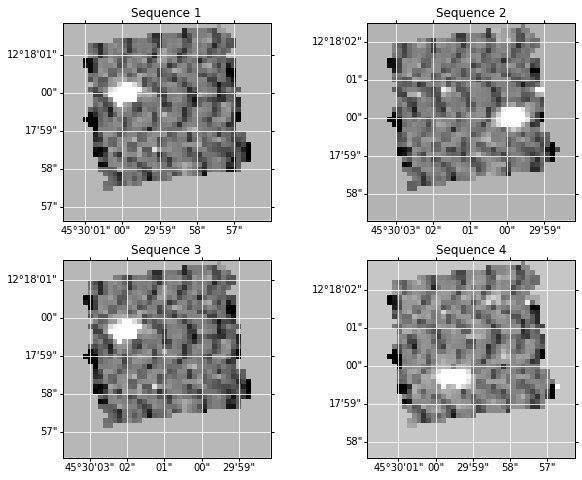

In [5]:
plt.figure(1, figsize=[10,8])

ifu1_data, ifu1_wcs = ifu1.data(sl)
plt.subplot(2,2,1, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

ifu2_data, ifu2_wcs = ifu2.data(sl)
plt.subplot(2,2,2, projection=ifu2_wcs)
show(ifu2_data, 'Sequence 2')

ifu3_data, ifu3_wcs = ifu3.data(sl)
plt.subplot(2,2,3, projection=ifu3_wcs)
show(ifu1_data, 'Sequence 3')

ifu4_data, ifu4_wcs = ifu4.data(sl)
plt.subplot(2,2,4, projection=ifu4_wcs)
show(ifu4_data, 'Sequence 4')


## Reproject onto a Common Grid

The next step will be to reproject them onto a common grid in order to do alignment.  To do the reprojection, the [reproject package](https://github.com/astrofrog/reproject) is used here.

For this, Sequence 2, Sequence 3 and Sequence 4 images will be reprojected onto Sequence 1.  This uses the WCS information used in each of the IFU cubes

In [6]:
ifu1_data, ifu1_wcs = ifu1.data(sl)
ifu2_data, ifu2_wcs = ifu2.data(sl)
ifu3_data, ifu3_wcs = ifu3.data(sl)
ifu4_data, ifu4_wcs = ifu4.data(sl)

ifu2_data_reproj, footprint2 = reproject_interp((ifu2_data, ifu2_wcs), ifu1_wcs, ifu1_data.shape)
ifu3_data_reproj, footprint3 = reproject_interp((ifu3_data, ifu3_wcs), ifu1_wcs, ifu1_data.shape)
ifu4_data_reproj, footprint4 = reproject_interp((ifu4_data, ifu4_wcs), ifu1_wcs, ifu1_data.shape)

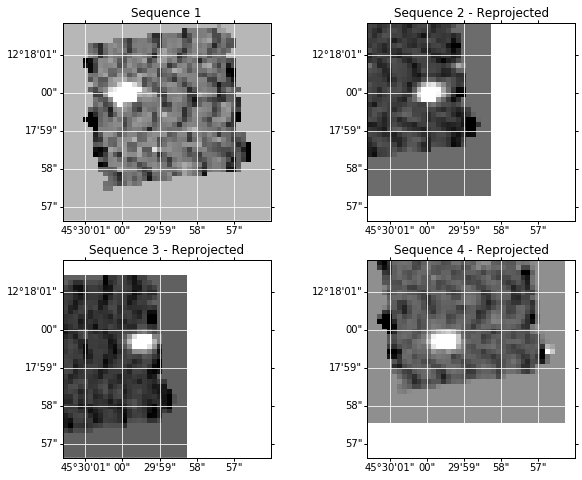

In [7]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj, 'Sequence 2 - Reprojected')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj, 'Sequence 3 - Reprojected')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj, 'Sequence 4 - Reprojected')


So, as expected, Sequence 1 and 2 are still centered at the correct location, but Sequence 3 and 4 are still shifted slightly lower and to the right.  But, at this point, all the images are in the same WCS frame (Sequence 1).

## Alignment

There is a package [image-registration](https://github.com/keflavich/image_registration) written by Adam Ginsburg that he has used for alignment and regisration using cross correlation, chi2 and a third algorithm.

### Cross Correlation

In [8]:
yoff, xoff = cross_correlation_shifts(ifu2_data_reproj, ifu1_data)
ifu2_data_reproj_ccreg = np.roll(np.roll(ifu2_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff = cross_correlation_shifts(ifu3_data_reproj, ifu1_data)
ifu3_data_reproj_ccreg = np.roll(np.roll(ifu3_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff = cross_correlation_shifts(ifu4_data_reproj, ifu1_data)
ifu4_data_reproj_ccreg = np.roll(np.roll(ifu4_data_reproj, int(yoff), 1), int(xoff), 0)

/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensiona

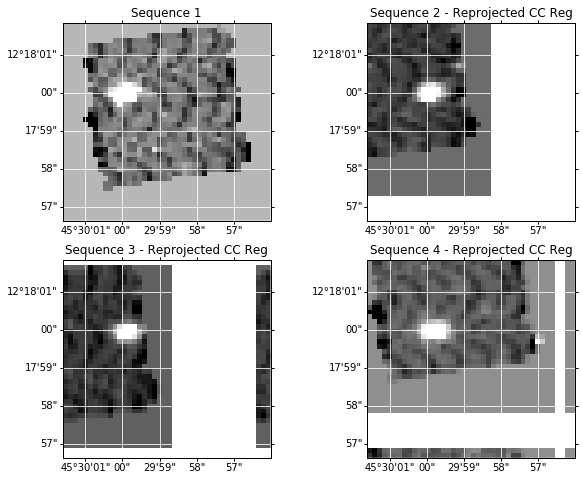

In [9]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_ccreg, 'Sequence 2 - Reprojected CC Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_ccreg, 'Sequence 3 - Reprojected CC Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_ccreg, 'Sequence 4 - Reprojected CC Reg')


### Chi2

In [10]:
yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu2_data_reproj, ifu1_data)
ifu2_data_reproj_chi2 = np.roll(np.roll(ifu2_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu3_data_reproj, ifu1_data)
ifu3_data_reproj_chi2 = np.roll(np.roll(ifu3_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff, edx, edy = chi2_shifts.chi2_shift(ifu4_data_reproj, ifu1_data)
ifu4_data_reproj_chi2 = np.roll(np.roll(ifu4_data_reproj, int(yoff), 1), int(xoff), 0)

/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/home/travis/miniconda/envs/test/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensiona

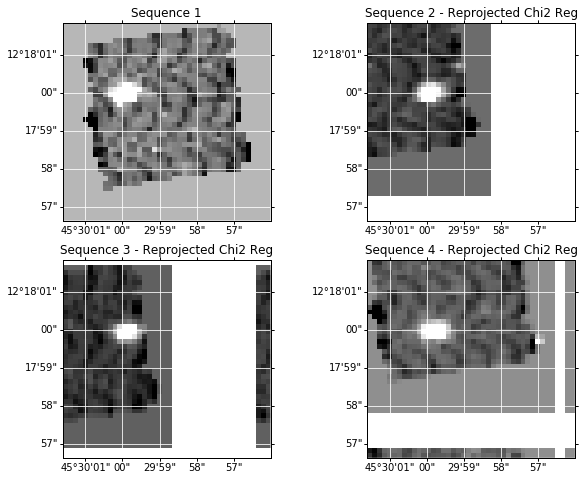

In [11]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_chi2, 'Sequence 2 - Reprojected Chi2 Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_chi2, 'Sequence 3 - Reprojected Chi2 Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_chi2, 'Sequence 4 - Reprojected Chi2 Reg')


### Sub-Pixel Image Registration

In [12]:
yoff, xoff = register_images(ifu2_data_reproj, ifu1_data)
ifu2_data_reproj_subpix = np.roll(np.roll(ifu2_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff = register_images(ifu3_data_reproj, ifu1_data)
ifu3_data_reproj_subpix = np.roll(np.roll(ifu3_data_reproj, int(yoff), 1), int(xoff), 0)

yoff, xoff = register_images(ifu4_data_reproj, ifu1_data)
ifu4_data_reproj_subpix = np.roll(np.roll(ifu4_data_reproj, int(yoff), 1), int(xoff), 0)

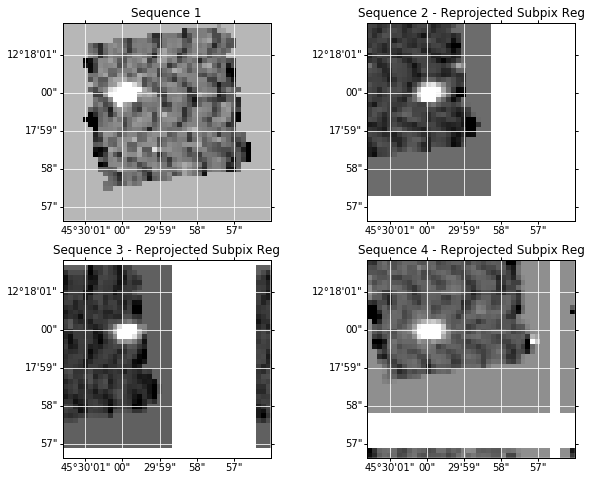

In [13]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data, 'Sequence 1')

plt.subplot(222, projection=ifu1_wcs)
show(ifu2_data_reproj_subpix, 'Sequence 2 - Reprojected Subpix Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu3_data_reproj_subpix, 'Sequence 3 - Reprojected Subpix Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu4_data_reproj_subpix, 'Sequence 4 - Reprojected Subpix Reg')

## Sum Images from Each Method

And finally, now that we have Sequences 2, 3 and 4 reprojected onto 1 and then aligned using several algorithms in the image-registration package, the sum of the 4 dithers can be calculated using the different methods. The first method is reprojection only and no alignment.

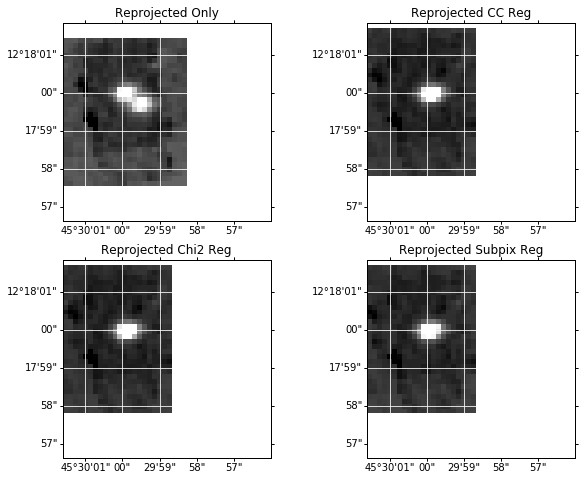

In [14]:
plt.figure(2,  figsize=[10,8])
plt.clf()
plt.subplot(221, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj + ifu3_data_reproj + ifu4_data_reproj, 
     'Reprojected Only')

plt.subplot(222, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_ccreg + ifu3_data_reproj_ccreg + ifu4_data_reproj_ccreg, 
     'Reprojected CC Reg')

plt.subplot(223, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_chi2 + ifu3_data_reproj_chi2 + ifu4_data_reproj_chi2, 
     'Reprojected Chi2 Reg')

plt.subplot(224, projection=ifu1_wcs)
show(ifu1_data + ifu2_data_reproj_subpix + ifu3_data_reproj_subpix + ifu4_data_reproj_subpix, 
     'Reprojected Subpix Reg')